In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize

In [60]:
#Load the data
df1 = pd.read_excel('weather_data.xls')
df2 = pd.read_excel('energy_consumption_data.xls')

In [3]:
#Extract columns that require interpolation
Hg = df1["high Gust Wind\xa0(km/h)"]
Ev = df1["Events"]
Hv = df1["high Visibility\xa0(km)"]
Av = df1["avg Visibility\xa0(km)"]
Lv = df1["low Visibility\xa0(km)"]
#Drop them to join them after interpolation
df1 = df1.drop(["high Gust Wind\xa0(km/h)"], axis = 1)
df1 = df1.drop(["Events"], axis = 1)
df1 = df1.drop(["high Visibility\xa0(km)"], axis = 1)
df1 = df1.drop(["avg Visibility\xa0(km)"], axis = 1)
df1 = df1.drop(["low Visibility\xa0(km)"], axis = 1)

In [4]:
Hg = Hg.replace('-', np.nan) #Make sure values of "-" are labeled as nan
Hg = Hg.interpolate(method='linear', limit_direction='backward', axis=0) #Interpolate for High Gust Wind
Ev = Ev.replace(' ', np.nan) #Make sure values of " " are labeled as nan
Ev = Ev.interpolate(method = 'pad') #Interpolate for Events
Hv = Hv.replace(' ', np.nan) #Make sure values of " " are labeled as nan
Hv = Hv.interpolate(method='linear', limit_direction='backward', axis=0) #Interpolate for High Visibility
Av = Av.replace(' ', np.nan) #Make sure values of " " are labeled as nan
Av = Av.interpolate(method='linear', limit_direction='backward', axis=0) #Interpolate for Avg Visibility
Lv = Lv.replace(' ', np.nan) #Make sure values of " " are labeled as nan
Lv = Lv.interpolate(method='linear', limit_direction='backward', axis=0) #Interpolate for Low Visibility

In [5]:
#Join the interpolated columns back
df1 = df1.join(Hg)
df1 = df1.join(Ev)
df1 = df1.join(Hv)
df1 = df1.join(Av)
df1 = df1.join(Lv)

<AxesSubplot:>

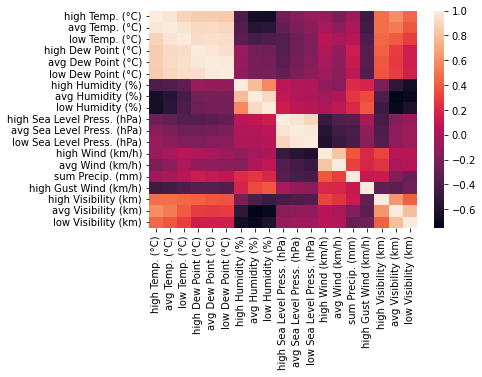

In [6]:
#Create correlation Heatmap
corr = df1.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [44]:
#Convert date column from object to datetime variable
df2["Date"] = pd.to_datetime(df2["Date"])
#Merge the two dataframes and synchronise date
Energy = df2["Energie journalière (MWh)"]
df3 = df1.join(Energy)

<AxesSubplot:xlabel='avg Temp.\xa0(°C)', ylabel='Energie journalière (MWh)'>

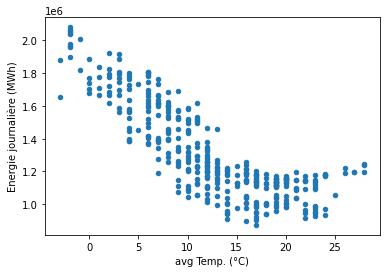

In [45]:
#Scatter plot for mean temperature vs energy consumption
df3.plot.scatter(x= "avg Temp.\xa0(°C)",y = "Energie journalière (MWh)")

In [46]:
#Create a quadratic model and use it to fit on the data
quad = np.polyfit(df3['avg Temp.\xa0(°C)'], df3['Energie journalière (MWh)'], 2)
model = np.poly1d(quad)
print(model)

      2
1567 x - 7.141e+04 x + 1.879e+06


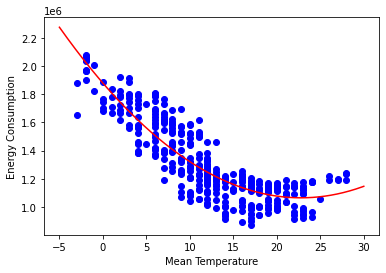

In [47]:
#Create data points for x (1000 points) and use it to plot the model
x = np.linspace(-5, 30, 1000)
y = (1567 * x**2) - (71410 * x) + 1879000
fig = plt.figure()

plt.plot(df3['avg Temp.\xa0(°C)'], df3['Energie journalière (MWh)'], 'bo', label='Data')

plt.xlabel('Mean Temperature', fontsize=10)
plt.ylabel('Energy Consumption', fontsize=10)
plt.plot(x,y, 'r', label = "Model")

plt.show()

In [49]:
#Now we find the global minima for the quadratic model we extracted 
quad_minimize = lambda x: (1567 * x**2) - (71410 * x) + 1879000
init = [-5.]
minima = minimize(quad_minimize, init)
print(f"Optimal temperature: {minima.x[0]}  Minimal Consumption: {quad_minimize(minima.x)[0]} " )

Optimal temperature: 22.785575136892785  Minimal Consumption: 1065440.9540523384 


In [50]:
#Code from the python stepwise_regression library: https://pypi.org/project/stepwise-regression/, 
#please refer to the link for further documentation
def backward_regression(X, y,
                           threshold_out,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included, model.summary()

In [51]:
#Drop catgorical features as well as our target
df4 = df3.drop(["Date", "Events", "Energie journalière (MWh)"], axis = 1)
target = np.array(df3["Energie journalière (MWh)"])
#I elect to use backwards stepwise regression and a threshold of 0.05
model1, summary1 = backward_regression(df4, target, 0.05)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

In [52]:
print(model1) #This gives us the list of variables chosen
print(summary1) #This gives us a summary that includes the R-squared value for the model

['avg Dew Point\xa0(°C)', 'high Humidity\xa0(%)', 'low Humidity\xa0(%)', 'high Gust Wind\xa0(km/h)', 'high Visibility\xa0(km)']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     232.6
Date:                Sun, 30 Jan 2022   Prob (F-statistic):          2.99e-110
Time:                        15:58:52   Log-Likelihood:                -4830.0
No. Observations:                 365   AIC:                             9672.
Df Residuals:                     359   BIC:                             9695.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025     

In [53]:
#Creating X-squared features
df5 = df4
for column in df5:
    df5[column+"_squared"] = df5[column]**2


In [54]:
#Again we fit the model on the new data but the target remains the same
model2, summary2 = backward_regression(df5, target, 0.05)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

In [55]:
print(model2) #This gives us the list of variables chosen after adding the new squared instances
print(summary2) #This gives us a summary that includes the R-squared value for the model after adding the new squared instances

['high Temp.\xa0(°C)', 'low Temp.\xa0(°C)', 'low Humidity\xa0(%)', 'high Sea Level Press.\xa0(hPa)', 'high Gust Wind\xa0(km/h)', 'high Visibility\xa0(km)', 'high Temp.\xa0(°C)_squared', 'low Temp.\xa0(°C)_squared', 'high Dew Point\xa0(°C)_squared', 'high Sea Level Press.\xa0(hPa)_squared', 'high Visibility\xa0(km)_squared']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     156.8
Date:                Sun, 30 Jan 2022   Prob (F-statistic):          1.59e-128
Time:                        15:58:58   Log-Likelihood:                -4770.2
No. Observations:                 365   AIC:                             9564.
Df Residuals:                     353   BIC:                             9611.
Df Model:                          11     

In [56]:
#Introducing dummy variables for day of the week
DoW = pd.Series(["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
dummies = pd.get_dummies(DoW)
dummies = pd.concat([dummies]*52) 
#Fit the variables length to our dataset
last_row = {"Monday":0, "Tuesday":0, "Wednesday":0, "Sunday":1, "Thursday":0, "Friday":0, "Saturday":0}
dummies = dummies.append(last_row, ignore_index = True)

In [57]:
df5 = pd.concat([df5, dummies], axis =1) #Adding the dummmies to our dataset

In [58]:
model3, summary3 = backward_regression(df5, target, 0.05)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

In [59]:
print(model3) #This gives us the list of variables chosen after adding the dummy vars
print(summary3) #This gives us a summary that includes the R-squared value for the model after adding the dummy vars

['high Temp.\xa0(°C)', 'low Temp.\xa0(°C)', 'low Humidity\xa0(%)', 'sum Precip.\xa0(mm)', 'high Gust Wind\xa0(km/h)', 'high Visibility\xa0(km)', 'high Temp.\xa0(°C)_squared', 'low Temp.\xa0(°C)_squared', 'high Dew Point\xa0(°C)_squared', 'high Sea Level Press.\xa0(hPa)_squared', 'avg Sea Level Press.\xa0(hPa)_squared', 'high Visibility\xa0(km)_squared', 'Friday', 'Monday', 'Saturday', 'Thursday', 'Tuesday', 'Wednesday']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     183.9
Date:                Sun, 30 Jan 2022   Prob (F-statistic):          8.23e-165
Time:                        15:59:12   Log-Likelihood:                -4663.4
No. Observations:                 365   AIC:                             9365.
Df Residuals:          